In [1]:
### In[1]: Notebook Setup and Imports
import pandas as pd
import numpy as np
import os
import glob
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# --- USER CONFIGURATION ---
REFERENCE_CSV_PATH = "/Users/ashkanhzdr/workspace/infectio-mesa/output/infectio_dVGFdF11/reference_metrics_for_M061M084M089_dVGFdF11_handpicked.csv"
EXPERIMENTS_ROOT_DIR = "/Users/ashkanhzdr/workspace/infectio-mesa/output/infectio_dVGFdF11/param1_csv"

METRICS_TO_PROCESS = [
    { "name": "Infected Count", "col": "inf-count-list" },
    { "name": "Plaque Area", "col": "area-list(um2)" },
    { "name": "Radial Velocity", "col": "radial-velocity-list(um/min)" }
]

In [4]:
SMOOTHING_WINDOW = 5 # The number of points to average over. Increase for more smoothing.
SLOPE_WEIGHT = 1.0   # How much to value the slope similarity.
MSE_WEIGHT = 1.0     # How much to value the overall error.

SCORING_FUNCTIONS = {}

# Each function must accept (metric_col_name, y_true, y_pred) and return a single score (float).

# helper function
def normalize_minmax_globally(y_true, y_pred):
    """
    Normalizes two series together using a global min/max scale by applying
    the formula manually.
    """
    if y_true.empty:
        return np.array([]), np.array([])

    # 1. Combine all data to find the global min and max
    all_values = np.concatenate([y_true.values, y_pred.values])
    global_min = all_values.min()
    global_max = all_values.max()

    # 2. Handle the edge case where all values are the same to avoid division by zero
    if global_min == global_max:
        return np.zeros_like(y_true.values, dtype=float), np.zeros_like(y_pred.values, dtype=float)

    # 3. Apply the scaling formula manually to each series
    range_ = global_max - global_min
    norm_y_true = (y_true.values - global_min) / range_
    norm_y_pred = (y_pred.values - global_min) / range_

    return norm_y_true, norm_y_pred

# helper function
def smooth_and_align_series(series1, series2, window_size):
    """
    Applies a moving average to two series and returns the smoothed,
    aligned results with NaNs removed.
    """
    # Ensure inputs are pandas Series to use the .rolling() method
    s1 = pd.Series(series1)
    s2 = pd.Series(series2)

    # Smooth each series individually
    s1_smooth = s1.rolling(window=window_size).mean()
    s2_smooth = s2.rolling(window=window_size).mean()

    # Combine into a DataFrame and drop rows with NaNs to ensure alignment
    combined_smooth = pd.DataFrame({'s1': s1_smooth, 's2': s2_smooth}).dropna()

    return combined_smooth['s1'], combined_smooth['s2']

def calculate_mae(metric_col_name, y_true, y_pred):
    """Calculates MAE for every metric passed to it."""
    if y_true.size == 0: return 0.0
    y_true_norm, y_pred_norm = normalize_minmax_globally(y_true, y_pred)
    return mean_absolute_error(y_true_norm, y_pred_norm)
SCORING_FUNCTIONS.update({'mae': calculate_mae})

def calculate_mse(metric_col_name, y_true, y_pred):
    """Calculates MSE for every metric passed to it."""
    if y_true.size == 0: return 0.0
    y_true_norm, y_pred_norm = normalize_minmax_globally(y_true, y_pred)
    return mean_squared_error(y_true_norm, y_pred_norm)
SCORING_FUNCTIONS.update({'mse': calculate_mse})

def calculate_mse_smooth(metric_col_name, ref_mean, exp_mean):
    """Calculates the total MSE on the smoothed version of the data."""
    y_true_norm, y_pred_norm = normalize_minmax_globally(ref_mean, exp_mean)
    if y_true_norm.size < SMOOTHING_WINDOW:
        return 0.0
    ref_smooth, exp_smooth = smooth_and_align_series(y_true_norm, y_pred_norm, SMOOTHING_WINDOW)
    if ref_smooth.empty:
        return 0.0
    return mean_squared_error(ref_smooth, exp_smooth)
SCORING_FUNCTIONS.update({'mse-smooth': calculate_mse_smooth})

# def calculate_mse_count_area(metric_col_name, y_true, y_pred):
#     """Calculates MSE but ONLY for 'inf-count-list' and 'area-list(um2)'."""
#     # Discard other metrics by returning 0
#     if metric_col_name not in ['inf-count-list', 'area-list(um2)']:
#         return 0.0
#     if y_true.size == 0: return 0.0
#     y_true_norm, y_pred_norm = normalize_minmax_globally(y_true, y_pred)
#     return mean_squared_error(y_true_norm, y_pred_norm)
# SCORING_FUNCTIONS.update({'mae': calculate_mae})

def calculate_mse_lastframe(metric_col_name, y_true, y_pred):
    """Calculates MSE on only the last time point of any metric."""
    if y_true.size == 0: return 0.0
    # Select only the last data point
    y_true_norm, y_pred_norm = normalize_minmax_globally(y_true, y_pred)
    return mean_squared_error([y_true_norm[-1]], [y_pred_norm[-1]])
SCORING_FUNCTIONS.update({'mse-lastframe': calculate_mse_lastframe})

# def calculate_mse_last_frame_area_only(metric_col_name, y_true, y_pred):
#     """Calculates MSE on the last frame, but ONLY for the 'area-list(um2)' metric."""
#     # Discard metrics that are not 'area'
#     if metric_col_name != 'area-list(um2)':
#         return 0.0
#     # Handle empty data
#     if y_true.size == 0: return 0.0
#     y_true_norm, y_pred_norm = normalize_minmax_globally(y_true, y_pred)
#     return mean_squared_error([y_true_norm[-1]], [y_pred_norm[-1]])

def calculate_slope_mse(metric_col_name, ref_mean, exp_mean):
    """
    Calculates the MSE of the slope (first difference) between two series.
    A lower score means the growth/decline patterns are more similar.
    """
    y_true_norm, y_pred_norm = normalize_minmax_globally(ref_mean, exp_mean)
    if y_true_norm.size < 2: # Need at least two points to calculate a difference
        return 0.0
    ref_growth = np.diff(y_true_norm)
    exp_growth = np.diff(y_pred_norm)
    return mean_squared_error(ref_growth, exp_growth)
SCORING_FUNCTIONS.update({'slope-mse': calculate_slope_mse})

# Test

unaligned_ref = pd.Series([0, 50, 100], index=[1, 2, 3])
unaligned_exp = pd.Series([25, 75],    index=[1, 2]) # Different length
# 2. Align the data exactly as it's done in your main processing loop
# This drops index '3' because it doesn't exist in unaligned_exp
aligned_df = pd.DataFrame({'ref': unaligned_ref, 'exp': unaligned_exp}).dropna()
test_ref = aligned_df['ref']
test_exp = aligned_df['exp']
norm_ref, norm_exp = normalize_minmax_globally(test_ref, test_exp)
print(f"Normalized Reference: {norm_ref}")
print(f"Normalized Experiment: {norm_exp}\n")

Normalized Reference: [0.         0.66666667]
Normalized Experiment: [0.33333333 1.        ]



In [22]:
def calculate_mse_smooth_plus_slope(metric_col_name, ytrue_mean, ypred_mean):
    """
    Calculates a combined score based on smoothed data.
    - Component 1: MSE on the smoothed lines.
    - Component 2: MSE on the slope of the smoothed lines.
    """
    # 1. Normalize the raw series to compare their shapes fairly
    ytrue_norm, ypred_norm = normalize_minmax_globally(ytrue_mean, ypred_mean)

    # Need enough data points for the moving average
    if ytrue_norm.size < SMOOTHING_WINDOW:
        return 0.0

    ytrue_smooth, ypred_smooth = smooth_and_align_series(ytrue_norm, ypred_norm, window_size=SMOOTHING_WINDOW)
    
    # After dropping NaNs, ensure series are still alignable and non-empty
    if ytrue_smooth.empty or len(ypred_smooth) < 2:
        return 0.0

    # 3. Calculate the MSE on the smoothed trendlines
    mse_smooth = mean_squared_error(ytrue_smooth, ypred_smooth)

    # 4. Calculate the MSE on the slope of the smoothed trendlines
    ytrue_growth_smooth = np.diff(ytrue_smooth)
    ypred_growth_smooth = np.diff(ypred_smooth)
    mse_slope_smooth = mean_squared_error(ytrue_growth_smooth, ypred_growth_smooth)

    # 5. Combine the scores using the defined weights
    final_score = (SLOPE_WEIGHT * mse_slope_smooth) + (MSE_WEIGHT * mse_smooth)
    
    return final_score
SCORING_FUNCTIONS.update({
    'custom-score': calculate_mse_smooth_plus_slope,
})

# much more weight for regression loss
def calculate_mse_smooth_plus_slope_2(metric_col_name, ytrue_mean, ypred_mean):
    """
    Calculates a combined score based on smoothed data.
    - Component 1: MSE on the smoothed lines.
    - Component 2: MSE on the slope of the smoothed lines.
    """
    # 1. Normalize the raw series to compare their shapes fairly
    ytrue_norm, ypred_norm = normalize_minmax_globally(ytrue_mean, ypred_mean)

    # Need enough data points for the moving average
    if ytrue_norm.size < SMOOTHING_WINDOW:
        return 0.0

    ytrue_smooth, ypred_smooth = smooth_and_align_series(ytrue_norm, ypred_norm, window_size=SMOOTHING_WINDOW)
    
    # After dropping NaNs, ensure series are still alignable and non-empty
    if ytrue_smooth.empty or len(ypred_smooth) < 2:
        return 0.0

    # 3. Calculate the MSE on the smoothed trendlines
    mse_smooth = mean_squared_error(ytrue_smooth, ypred_smooth)

    # 4. Calculate the MSE on the slope of the smoothed trendlines
    ytrue_growth_smooth = np.diff(ytrue_smooth)
    ypred_growth_smooth = np.diff(ypred_smooth)
    mse_slope_smooth = mean_squared_error(ytrue_growth_smooth, ypred_growth_smooth)

    # 5. Combine the scores using the defined weights
    final_score = (0.1 * mse_slope_smooth) + (1.0 * mse_smooth)
    
    return final_score
SCORING_FUNCTIONS.update({
    'custom-score-2': calculate_mse_smooth_plus_slope_2,
})

In [23]:
def get_stats_from_file(filepath, column_name):
    df = pd.read_csv(filepath)
    df.set_index('t', inplace=True)
    list_series = df[column_name].apply(ast.literal_eval)
    mean_series = list_series.apply(np.mean)
    std_series = list_series.apply(np.std)
    return mean_series, std_series

reference_data = {}
print(f"Loading reference data from: {REFERENCE_CSV_PATH}")
try:
    for metric in METRICS_TO_PROCESS:
        col_name = metric['col']
        reference_data[col_name] = get_stats_from_file(REFERENCE_CSV_PATH, col_name)
    print("Reference data (mean and std) processed successfully.")
except Exception as e:
    print(f"AN ERROR OCCURRED: {e}")

Loading reference data from: /Users/ashkanhzdr/workspace/infectio-mesa/output/infectio_dVGFdF11/reference_metrics_for_M061M084M089_dVGFdF11_handpicked.csv
Reference data (mean and std) processed successfully.


In [24]:
experiment_files = glob.glob(os.path.join(EXPERIMENTS_ROOT_DIR, '*.csv'))
results = []

if not experiment_files:
    print(f"ERROR: No CSV files found in '{EXPERIMENTS_ROOT_DIR}'.")
else:
    print(f"Found {len(experiment_files)} experiments to process. Starting scoring...")
    for filepath in experiment_files:
        experiment_name = os.path.basename(filepath).replace('.csv', '')
        score_totals = {name: 0.0 for name in SCORING_FUNCTIONS.keys()}
        error_occurred = False

        for metric in METRICS_TO_PROCESS:
            col_name = metric['col']
            if col_name not in reference_data: continue

            try:
                ref_mean_notaligned, _ = reference_data[col_name]
                exp_mean_notaligned, _ = get_stats_from_file(filepath, col_name)
                
                # Align the two series, creating the comparison_df
                comparison_df = pd.DataFrame({'ref': ref_mean_notaligned, 'exp': exp_mean_notaligned}).dropna()
                
                # Extract the aligned (but raw) series
                ref_mean = comparison_df['ref']
                exp_mean = comparison_df['exp']
                
                # Calculate all scores for the current metric
                for score_name, score_func in SCORING_FUNCTIONS.items():
                    score = score_func(col_name, ref_mean, exp_mean)
                    score_totals[score_name] += score
                        
            except Exception as e:
                print(f"ERROR during scoring for file {filepath} and metric {col_name}: {e}")
                error_occurred = True
                break
        
        if not error_occurred:
            result_row = {'parameters': experiment_name}
            result_row.update(score_totals)
            results.append(result_row)
            
    print("Scoring complete.")

Found 2160 experiments to process. Starting scoring...
Scoring complete.


In [25]:
def parse_parameters(filename):
    params = {}
    parts = filename.split('-')
    for part in parts:
        if '=' in part:
            key, value = part.split('=', 1)
            try: params[key] = float(value)
            except ValueError:
                try: params[key] = int(value)
                except ValueError: params[key] = value
    return params

results_df = pd.DataFrame(results)
param_dicts = results_df['parameters'].apply(parse_parameters)
params_df = pd.json_normalize(param_dicts)
results_df = pd.concat([results_df, params_df], axis=1)

display(results_df)

parameters       mae       mse  \
0     randomwalk_speed=0.25-c2c_sigmoid_k=1-c2c_sigm...  1.074619  0.440045   
1     randomwalk_speed=0.5-c2c_sigmoid_k=1-c2c_sigmo...  0.519175  0.195137   
2     randomwalk_speed=0.5-c2c_sigmoid_k=0.1-c2c_sig...  0.564523  0.142265   
3     randomwalk_speed=0.75-c2c_sigmoid_k=0.01-c2c_s...  0.626547  0.164675   
4     randomwalk_speed=0.75-c2c_sigmoid_k=1-c2c_sigm...  0.606141  0.154860   
...                                                 ...       ...       ...   
2155  randomwalk_speed=0.5-c2c_sigmoid_k=0.01-c2c_si...  1.067190  0.553656   
2156  randomwalk_speed=0.6-c2c_sigmoid_k=0.01-c2c_si...  0.654712  0.205054   
2157  randomwalk_speed=0.25-c2c_sigmoid_k=0.01-c2c_s...  1.081318  0.442789   
2158  randomwalk_speed=0.25-c2c_sigmoid_k=0.01-c2c_s...  1.217382  0.542025   
2159  randomwalk_speed=0.75-c2c_sigmoid_k=0.1-c2c_si...  1.228749  0.652445   

      mse-smooth  mse-lastframe  slope-mse  custom-score  custom-score-2  \
0       0.443255       0.289142   0.018241      0.444379        0.443368   
1       0.161530       1.046163   0.017363      0.162641        0.161641   
2       0.134274       0.110351   0.018348      0.135066        0.134353   
3       0.147478       0.274051   0.012661      0.148141        0.147544   
4       0.136833       0.260564   0.013565      0.137646        0.136914   
...          ...            ...        ...           ...             ...   
2155    0.527573       1.442245   0.018349      0.528567        0.527672   
2156    0.192109       0.330221   0.017877      0.192868        0.192184   
2157    0.444935       0.407559   0.018195      0.445680        0.445009   
2158    0.541858       0.658485   0.018319      0.542642        0.541936   
2159    0.620489       1.657550   0.014095      0.621338        0.620573   

      randomwalk_speed  c2c_sigmoid_k  c2c_sigmoid_t0  c2c_sigmoid_tmid  \
0                 0.25           1.00            36.0              48.0   
1                 0.50           1.00            24.0              64.0   
2                 0.50           0.10            24.0              48.0   
3                 0.75           0.01            12.0              48.0   
4                 0.75           1.00            12.0              48.0   
...                ...            ...             ...               ...   
2155              0.50           0.01            12.0              24.0   
2156              0.60           0.01            24.0              36.0   
2157              0.25           0.01            24.0              48.0   
2158              0.25           0.01            12.0              48.0   
2159              0.75           0.10            12.0              24.0   

      c2c_radius_search  first_cell_lag  
0                  35.0            24.0  
1                  25.0             8.0  
2                  25.0             8.0  
3                  20.0            48.0  
4                  25.0            48.0  
...                 ...             ...  
2155               35.0             8.0  
2156               30.0             8.0  
2157               30.0             8.0  
2158               25.0            48.0  
2159               30.0             8.0  

[2160 rows x 14 columns]

In [ ]:
SORT_BY_METRIC = 'mse-lastframe'
# 'total-mse' 'mse-last_frame_area' 'slope-mse'
START_RANK = 1
END_RANK = 25

###
results_df = results_df.sort_values(by=SORT_BY_METRIC, ascending=True).reset_index(drop=True)

### In[9]: Generate and Display Plots with Std Bands
start_index = START_RANK - 1
end_index = END_RANK
if start_index < 0 or end_index > len(results_df):
    print(f"ERROR: Invalid rank range. Please choose between 1 and {len(results_df)}.")
else:
    experiments_to_plot = results_df.iloc[start_index:end_index]
    print(f"\nGenerating {len(experiments_to_plot)} plot(s)...")
    for index, row in experiments_to_plot.iterrows():
        param_string = row['parameters']
        filepath = os.path.join(EXPERIMENTS_ROOT_DIR, param_string + '.csv')
        score = row[SORT_BY_METRIC]
        rank = index + 1
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18), sharex=True)
        fig.suptitle(f"Population Comparison for Rank #{rank}\n{SORT_BY_METRIC}: {score:.4f}", fontsize=16, y=0.99)
        print(filepath)
        for i, metric in enumerate(METRICS_TO_PROCESS):
            ax = axes[i]
            col_name = metric['col']
            try:
                # The line that causes the error
                ref_mean, ref_std = reference_data[col_name]
                exp_mean, exp_std = get_stats_from_file(filepath, col_name)

                ax.plot(ref_mean.index, ref_mean, color='black', linewidth=2, label='Reference Mean')
                ax.fill_between(ref_mean.index, ref_mean - ref_std, ref_mean + ref_std, color='black', alpha=0.2, label='Reference Std Dev')
                ax.plot(exp_mean.index, exp_mean, color='#0072B2', linewidth=2, label='Experiment Mean')
                ax.fill_between(exp_mean.index, exp_mean - exp_std, exp_mean + exp_std, color='#0072B2', alpha=0.2, label='Experiment Std Dev')
                ax.set_ylabel(metric['name'])
                ax.legend()
                ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            except Exception as e:
                print(f"\n--- AN ERROR OCCURRED IN THE PLOTTING LOOP ---")
                print(f"Attempting to plot for Rank {rank}, Metric '{col_name}'")
                print(f"The error was: {e}")
                # This will print the debug info again for the specific failing key
                print(f"\nRe-inspecting the problematic value from the dictionary:")
                problem_value = reference_data.get(col_name, "KEY NOT FOUND")
                print(f"Value for key '{col_name}' is: {problem_value}")
                print(f"Type of value is: {type(problem_value)}")
                if isinstance(problem_value, tuple):
                    print(f"Length of tuple is: {len(problem_value)}")
                print("--- END OF PLOTTING ERROR DEBUG ---")

        axes[-1].set_xlabel("Time (hpi)")
        fig.align_ylabels(axes)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("new Line: -------")
    print("\nFinished generating plots.")

Comparing Top 10 experiments for 'mse-lastframe' vs. 'custom-score-2'...


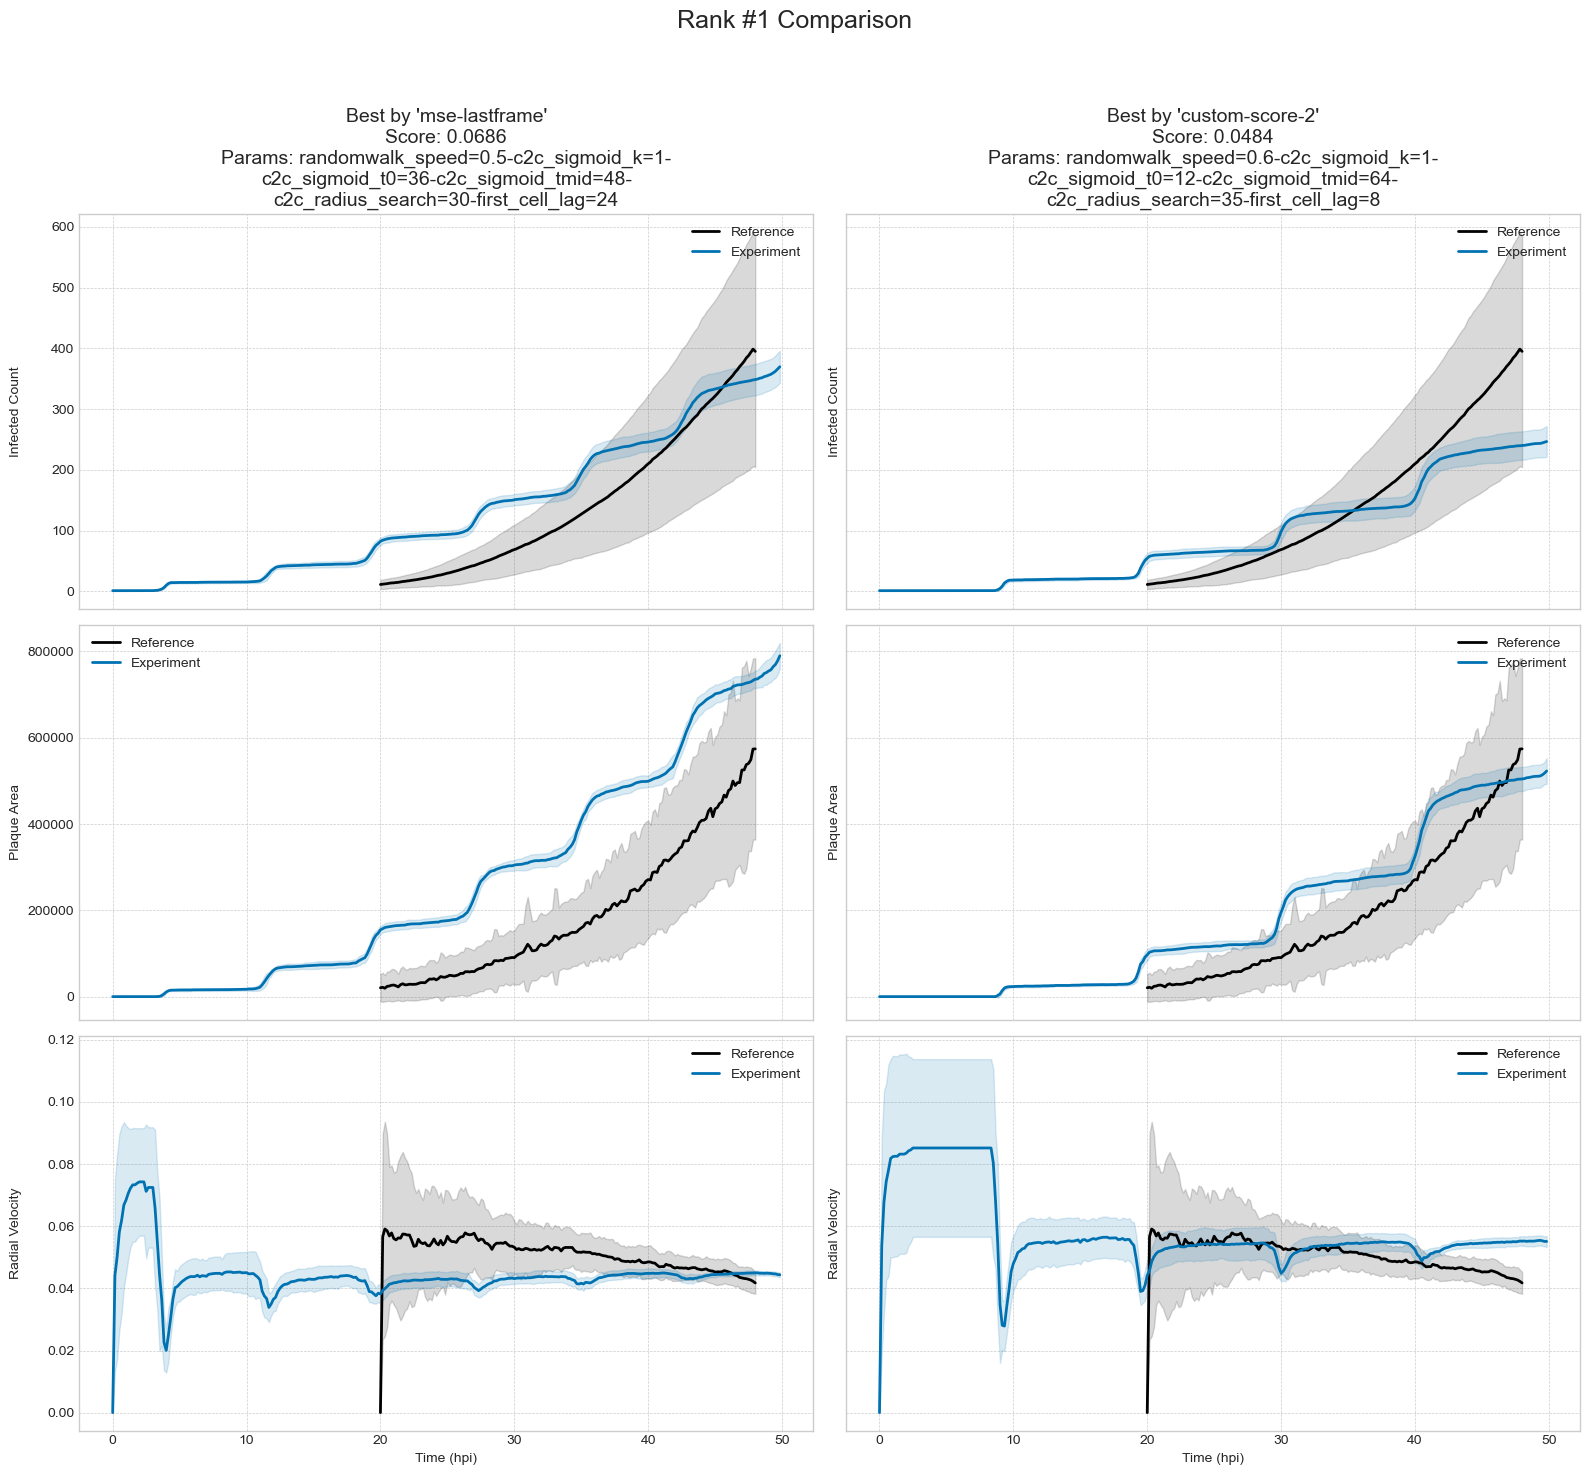

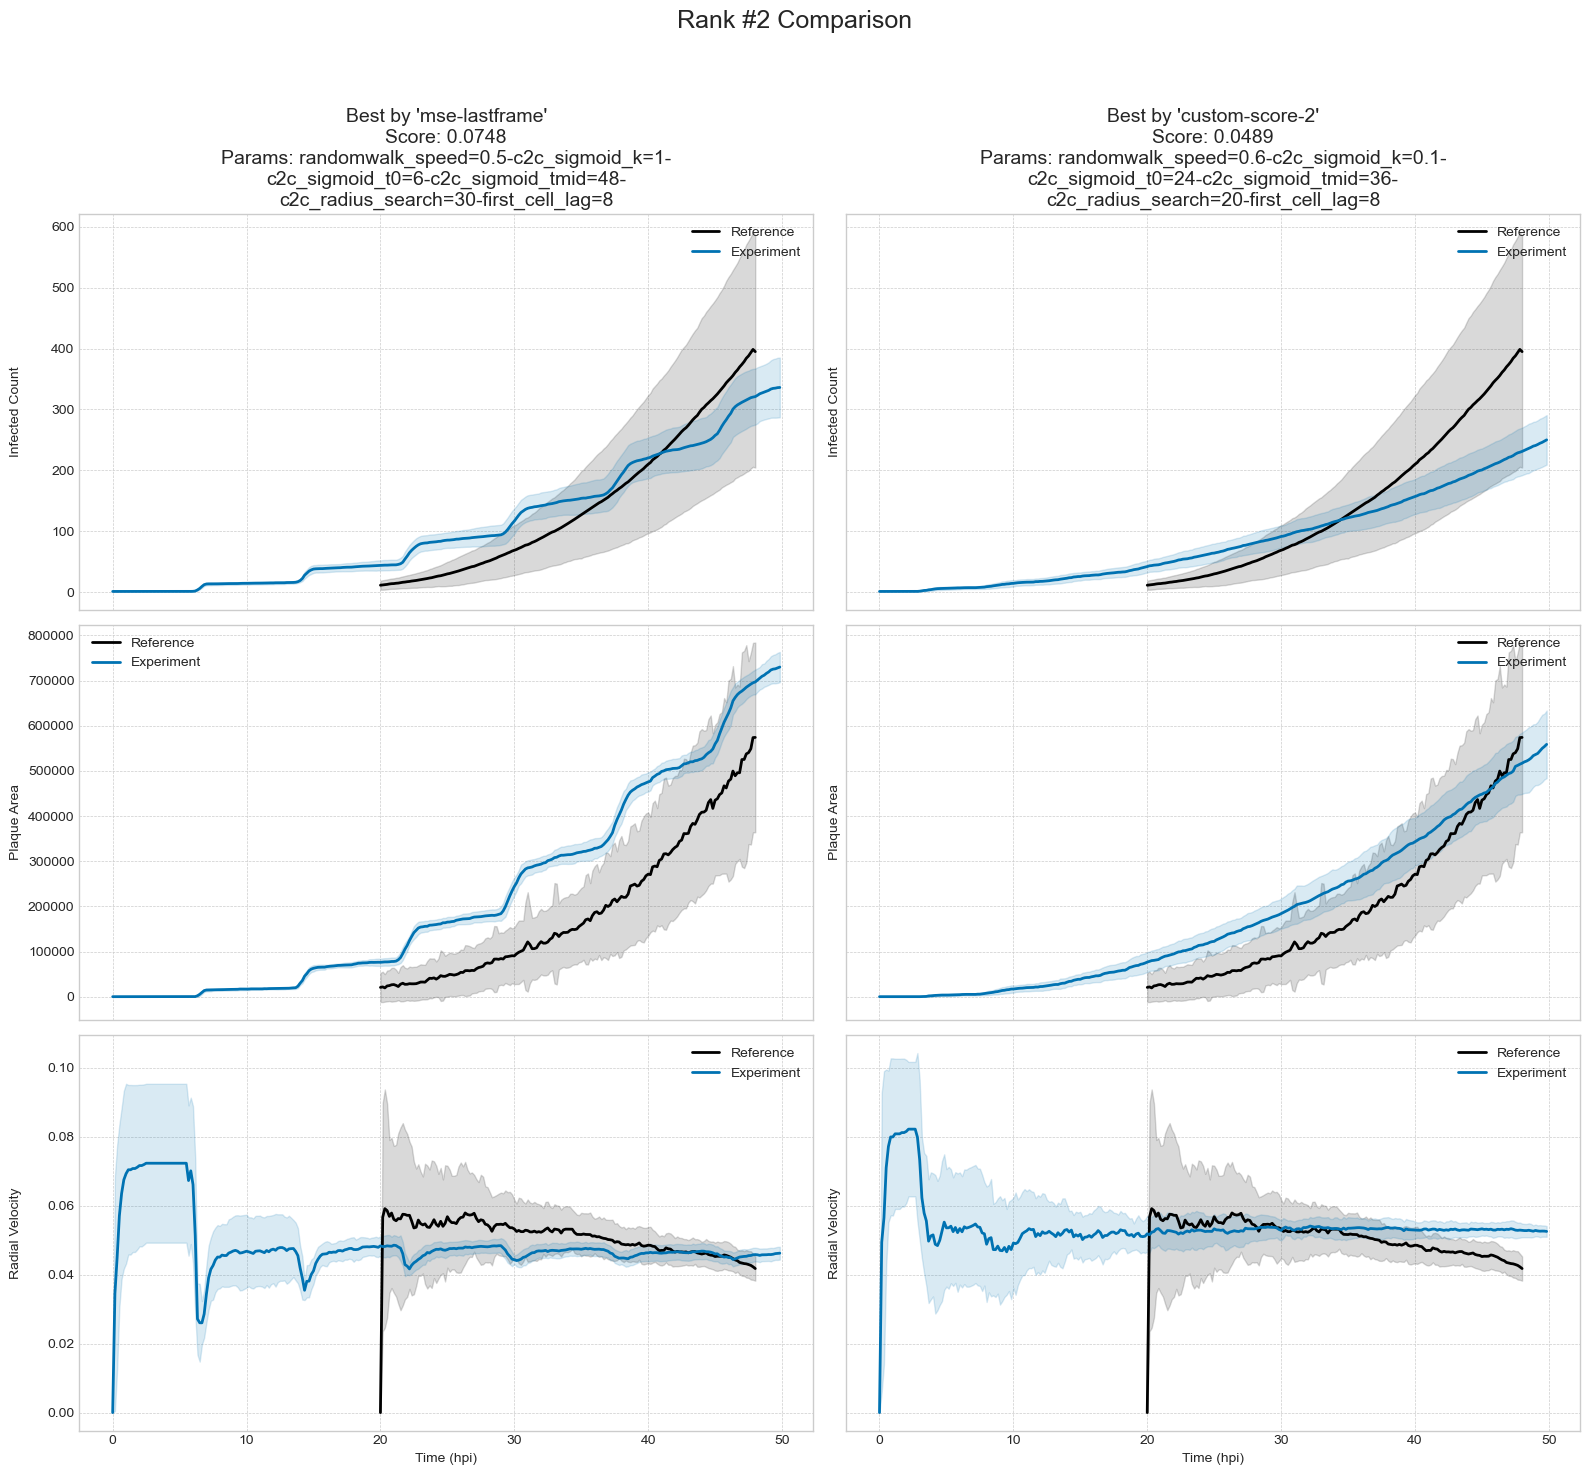

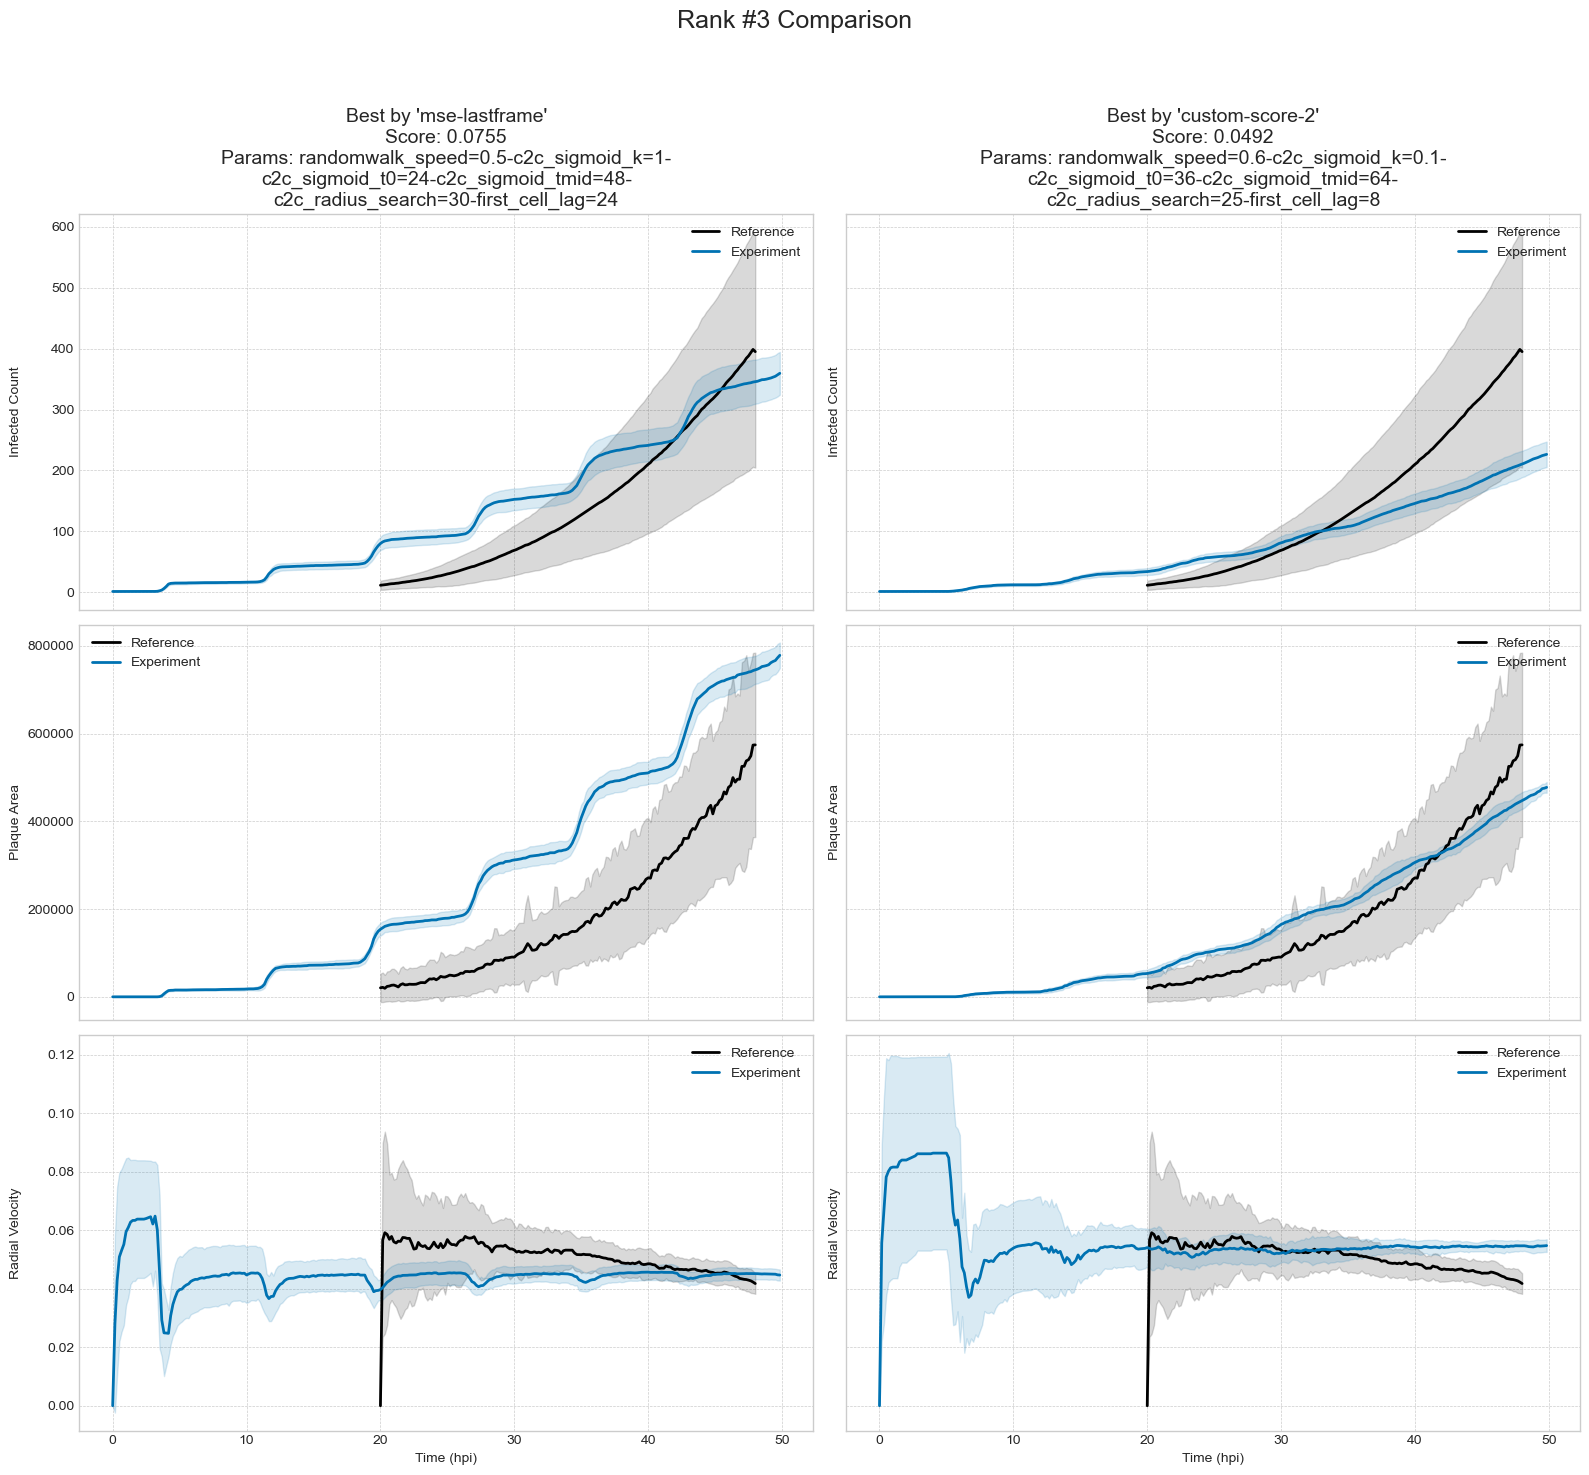

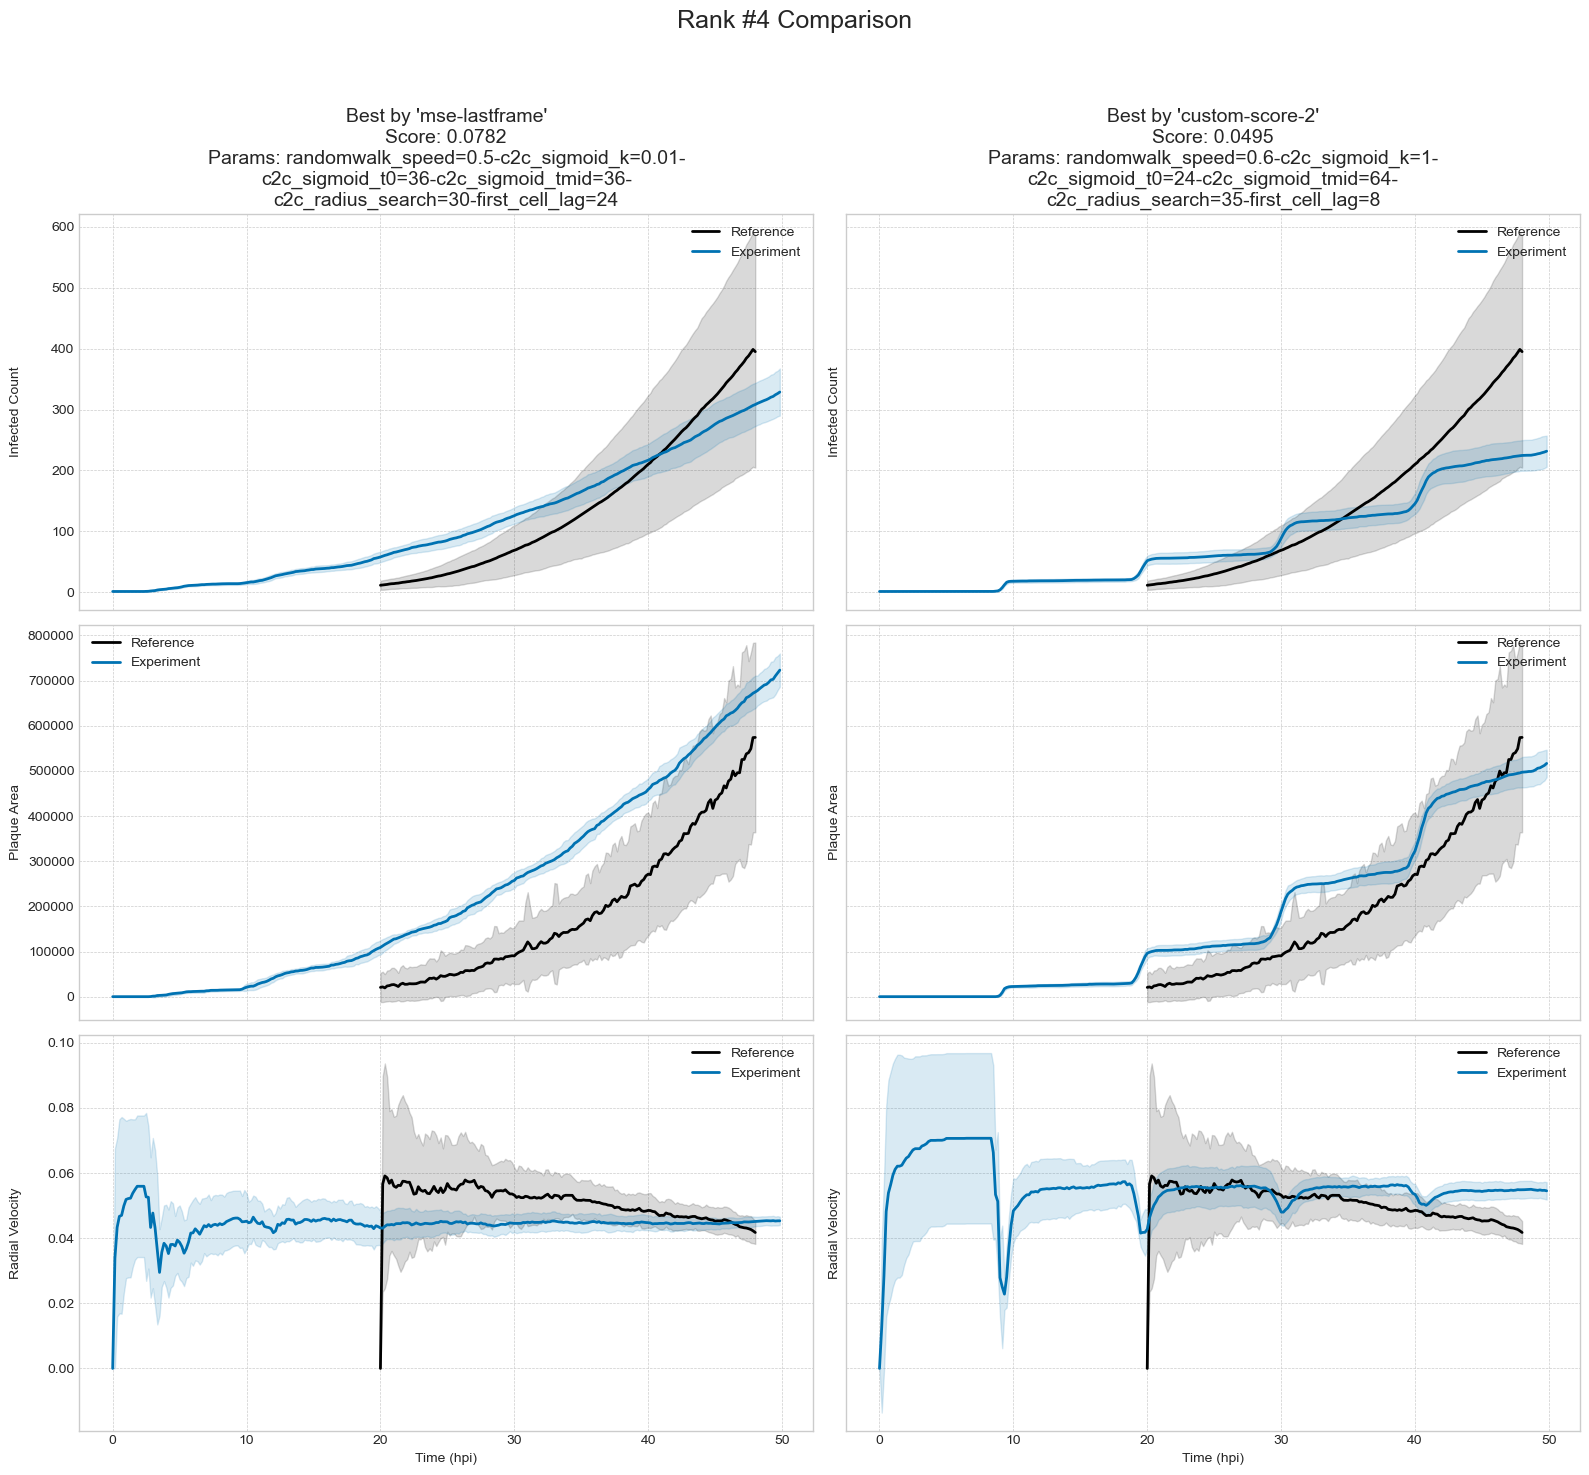

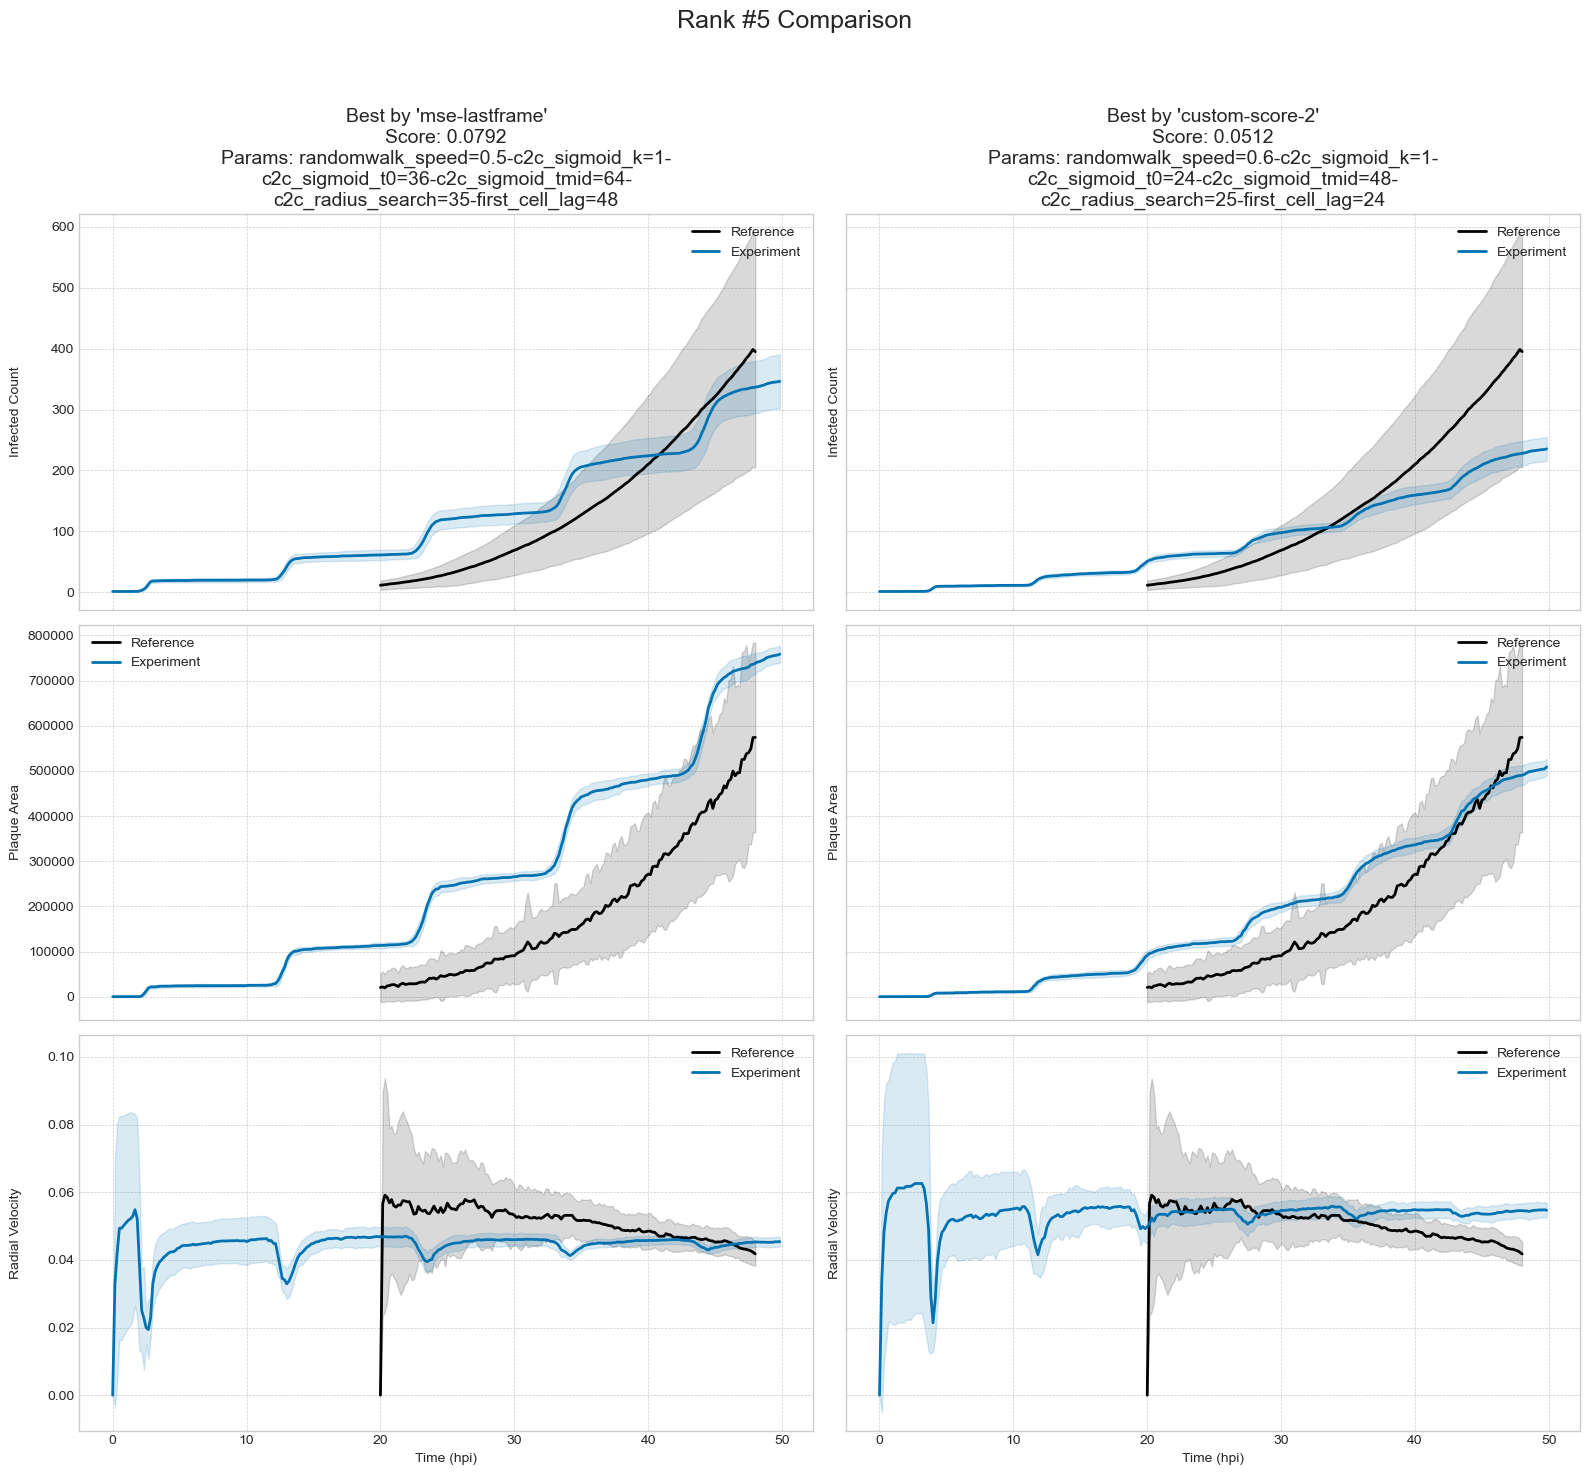

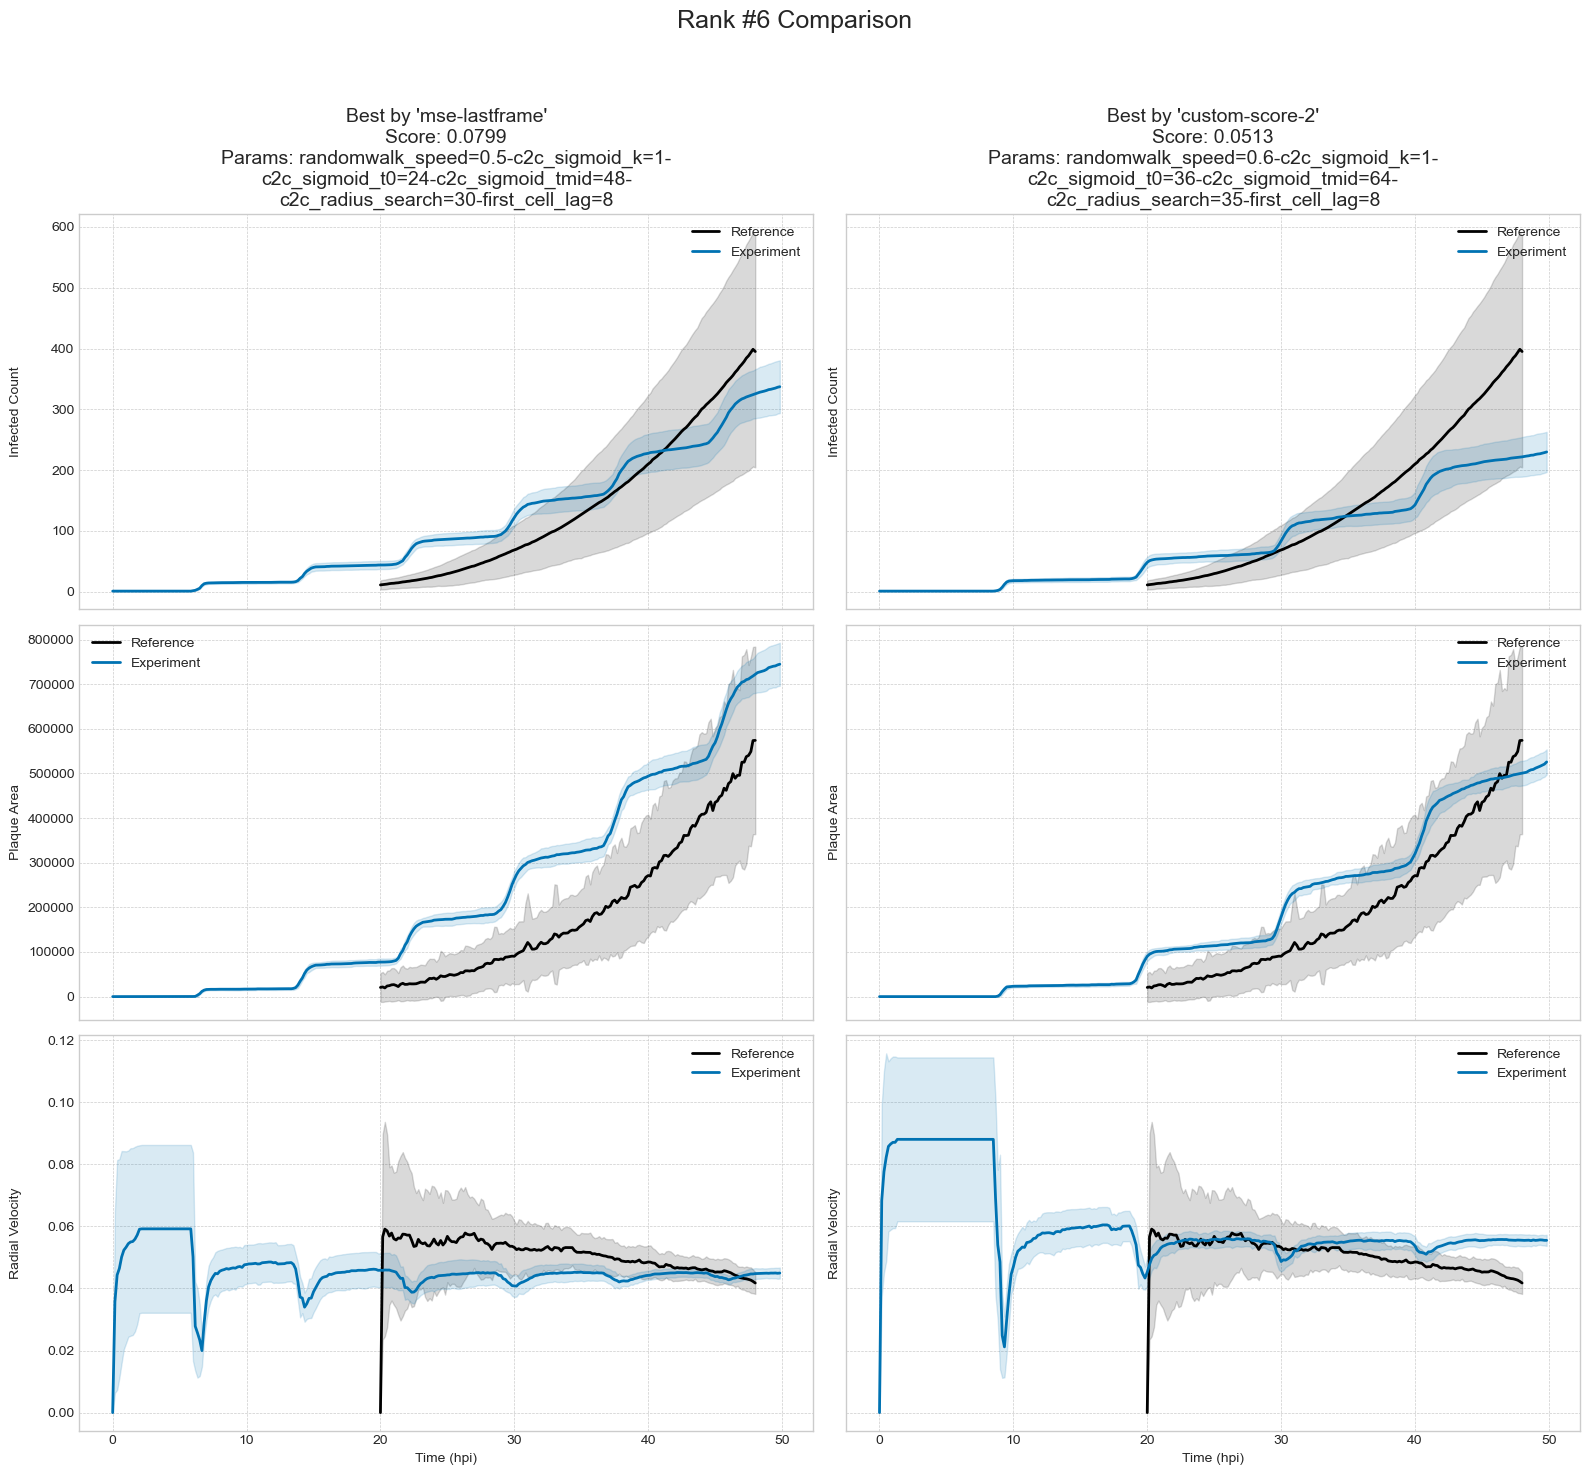

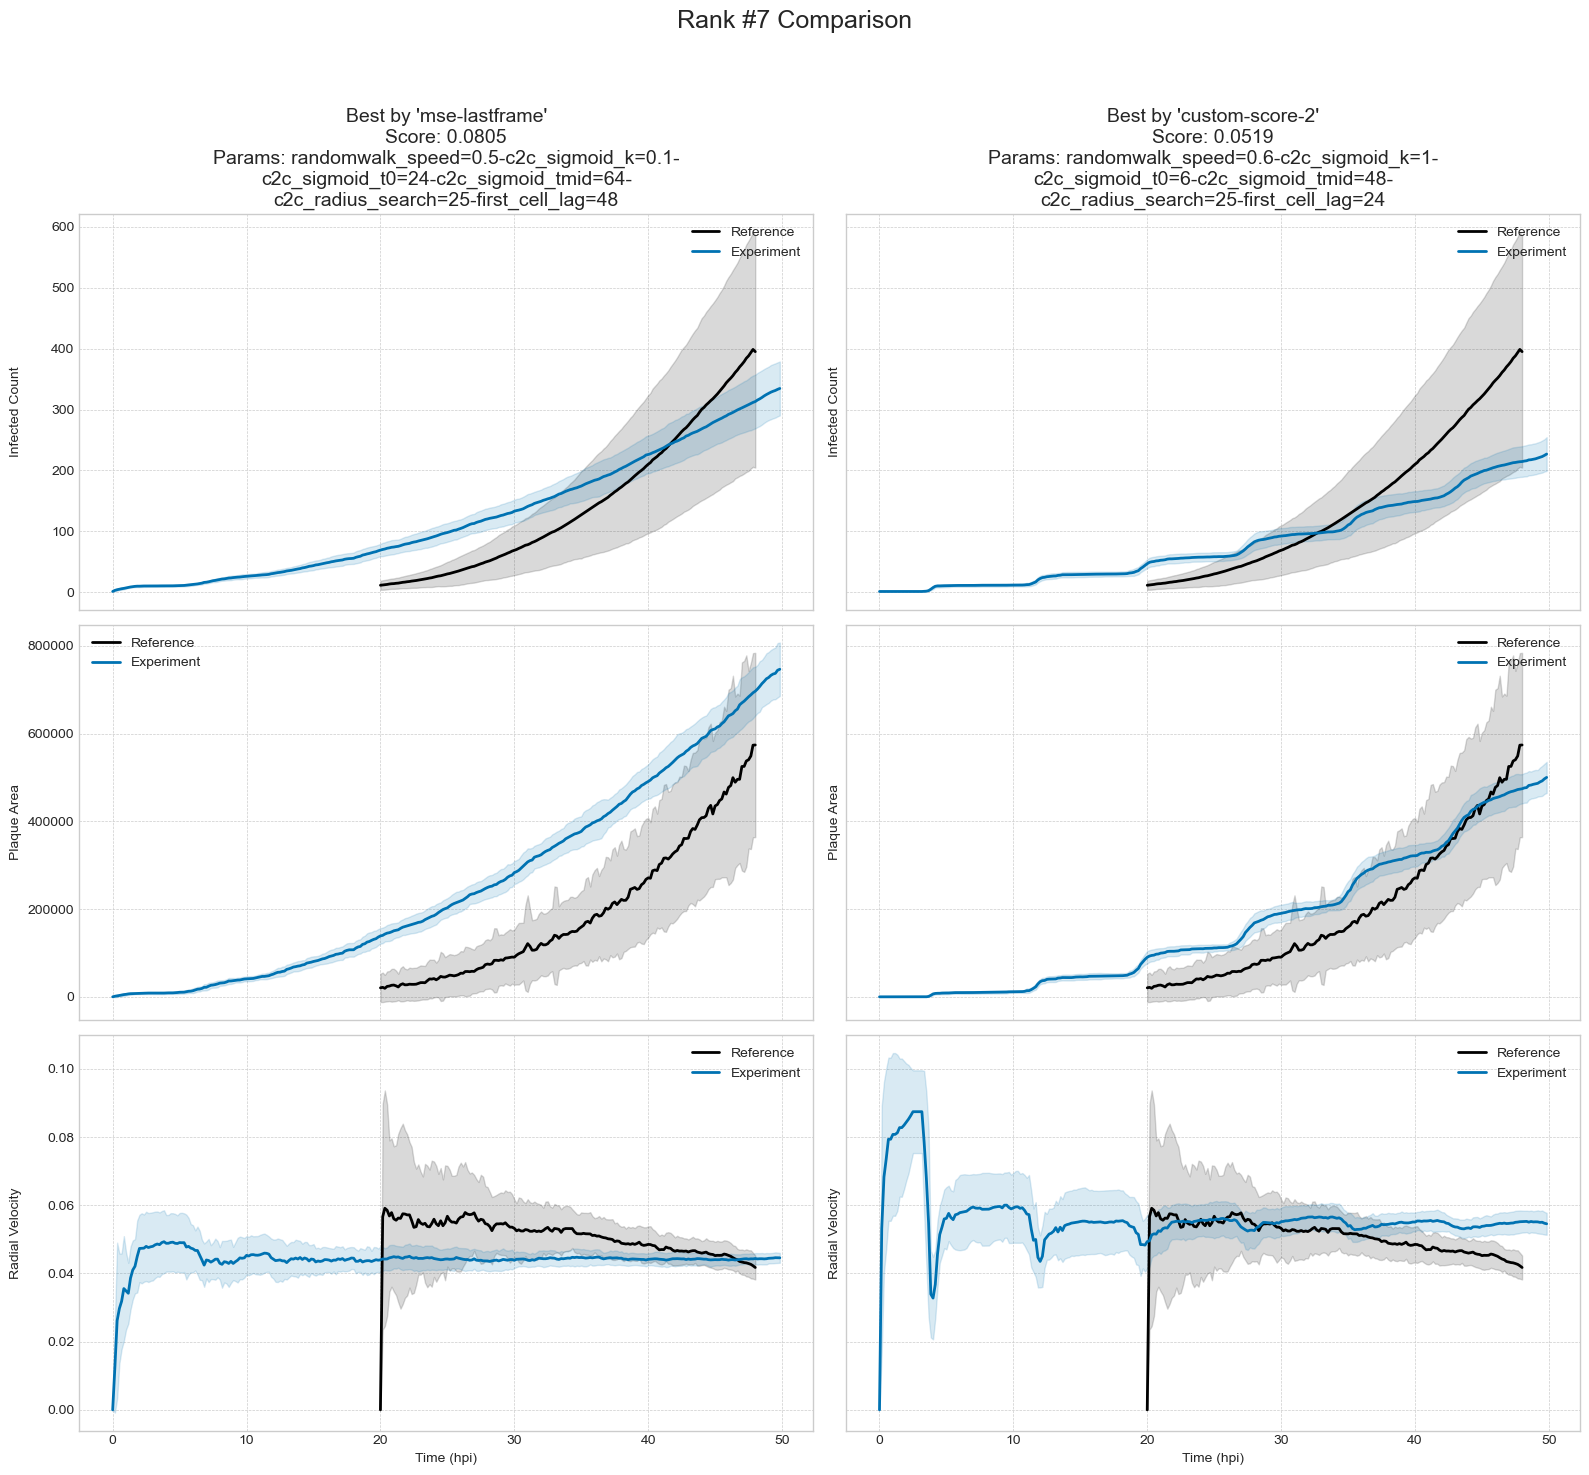

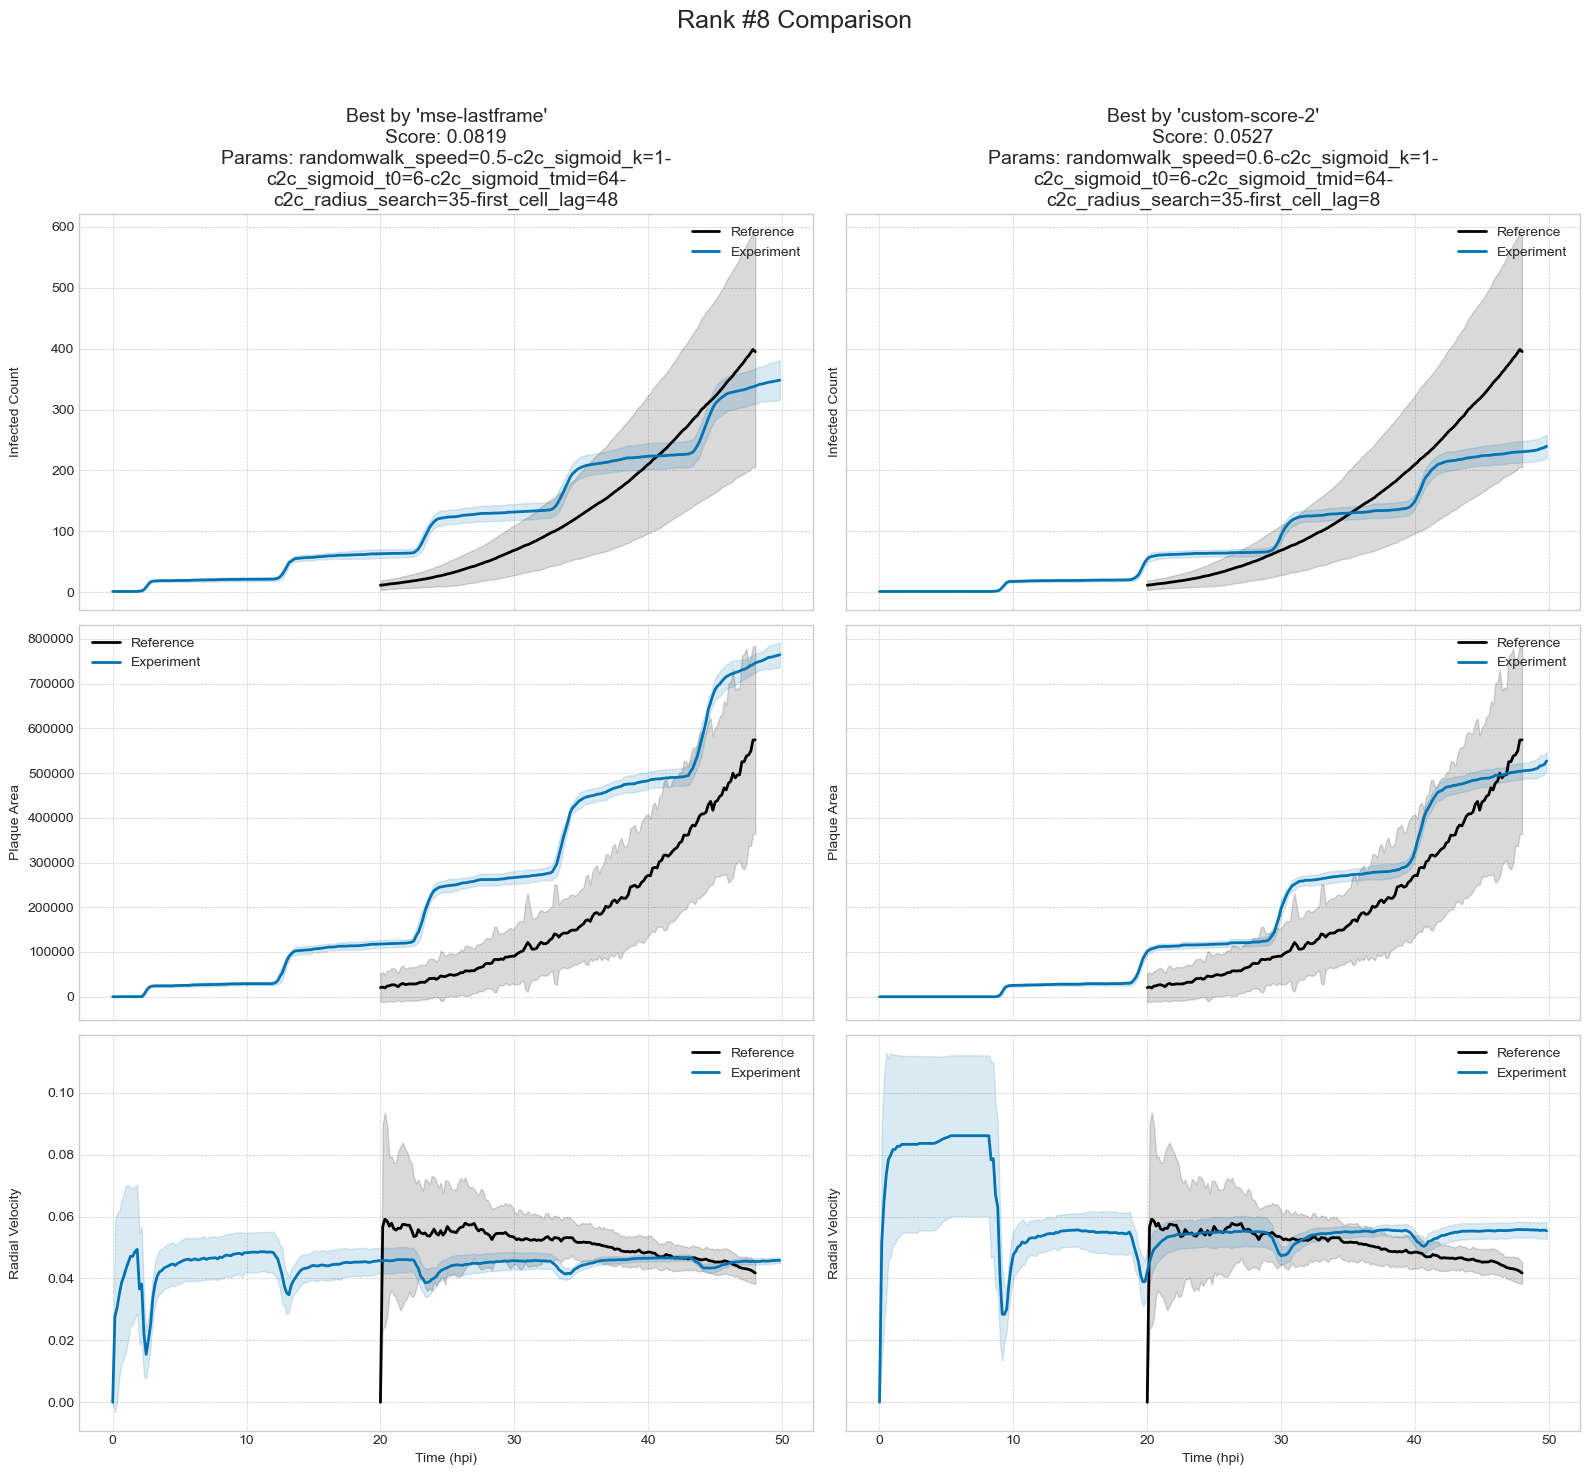

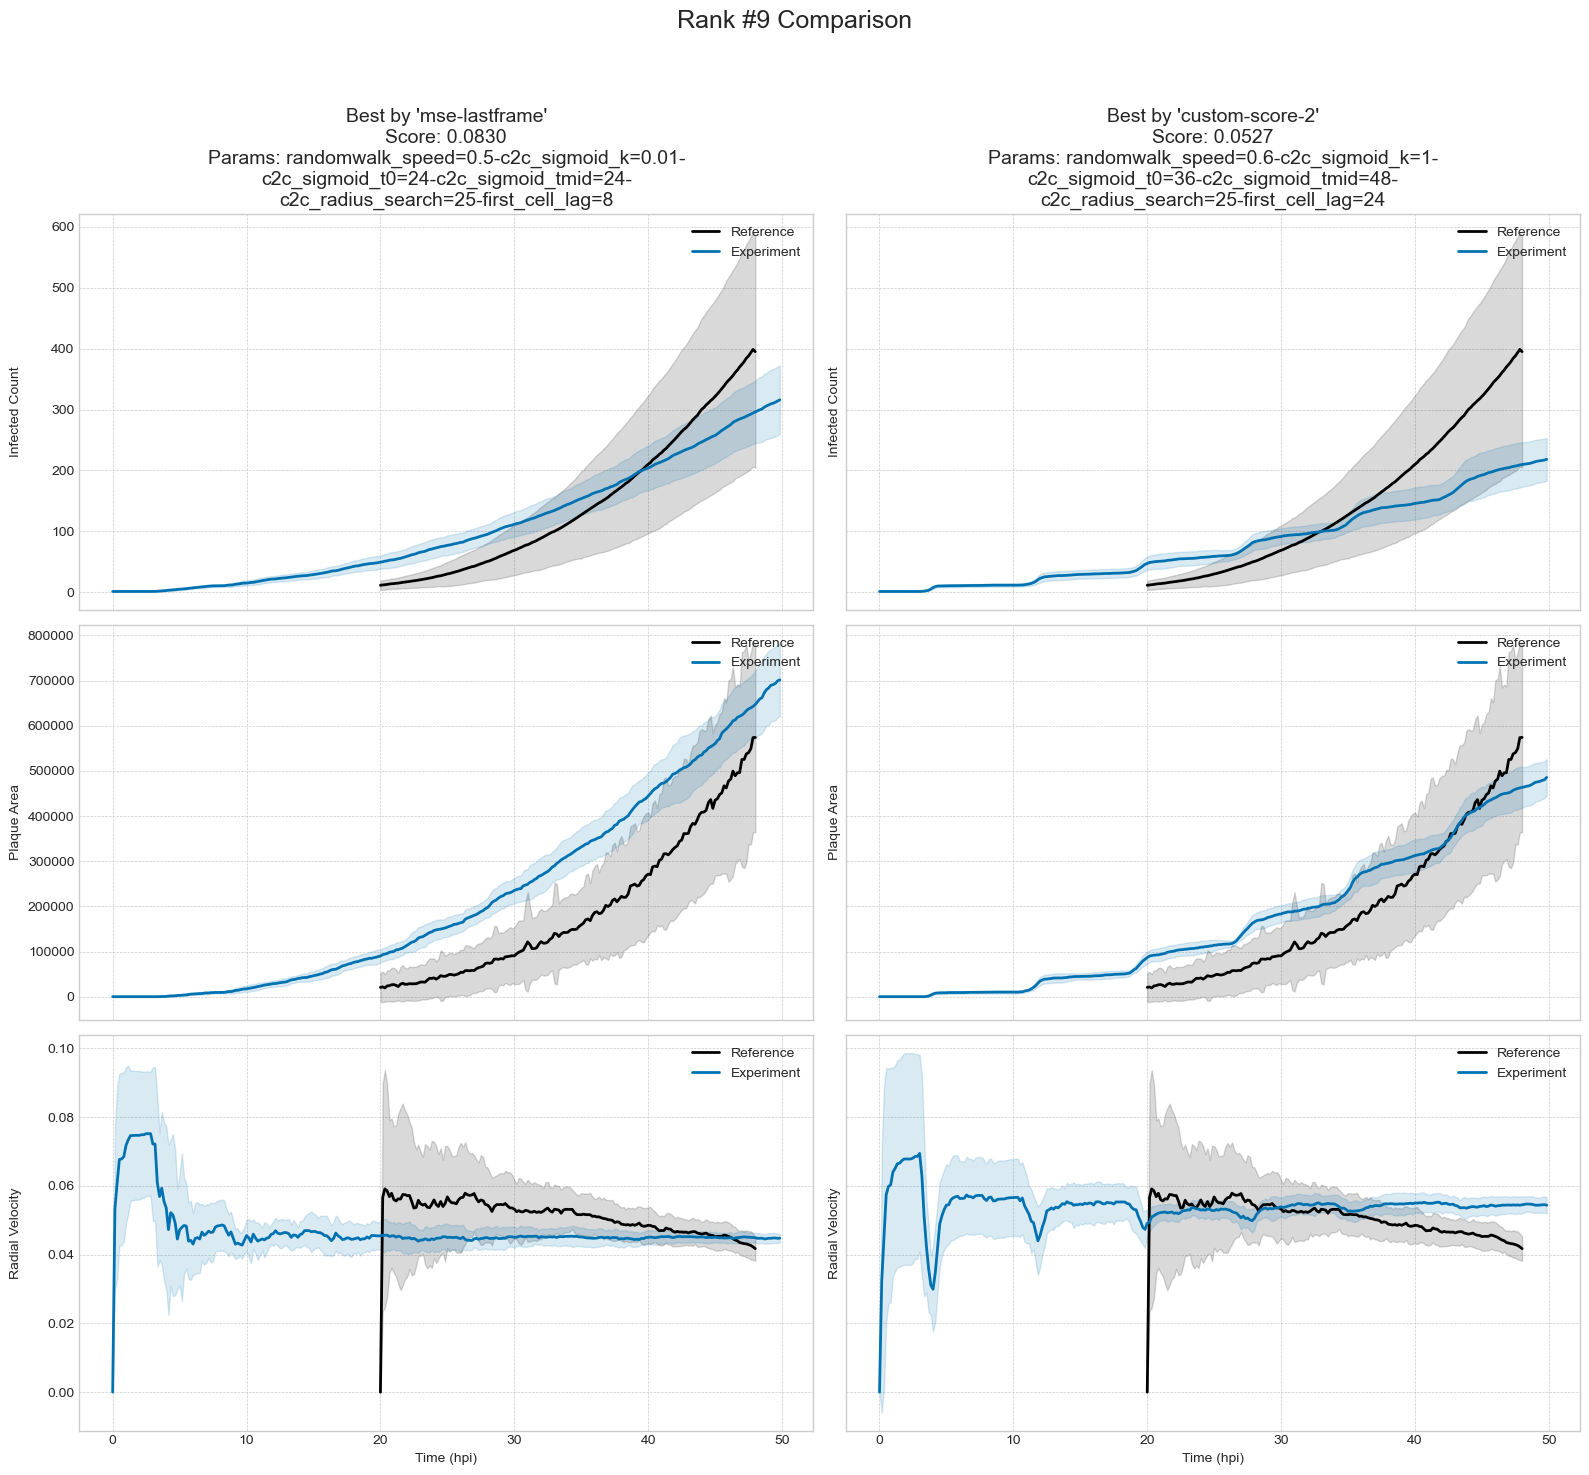

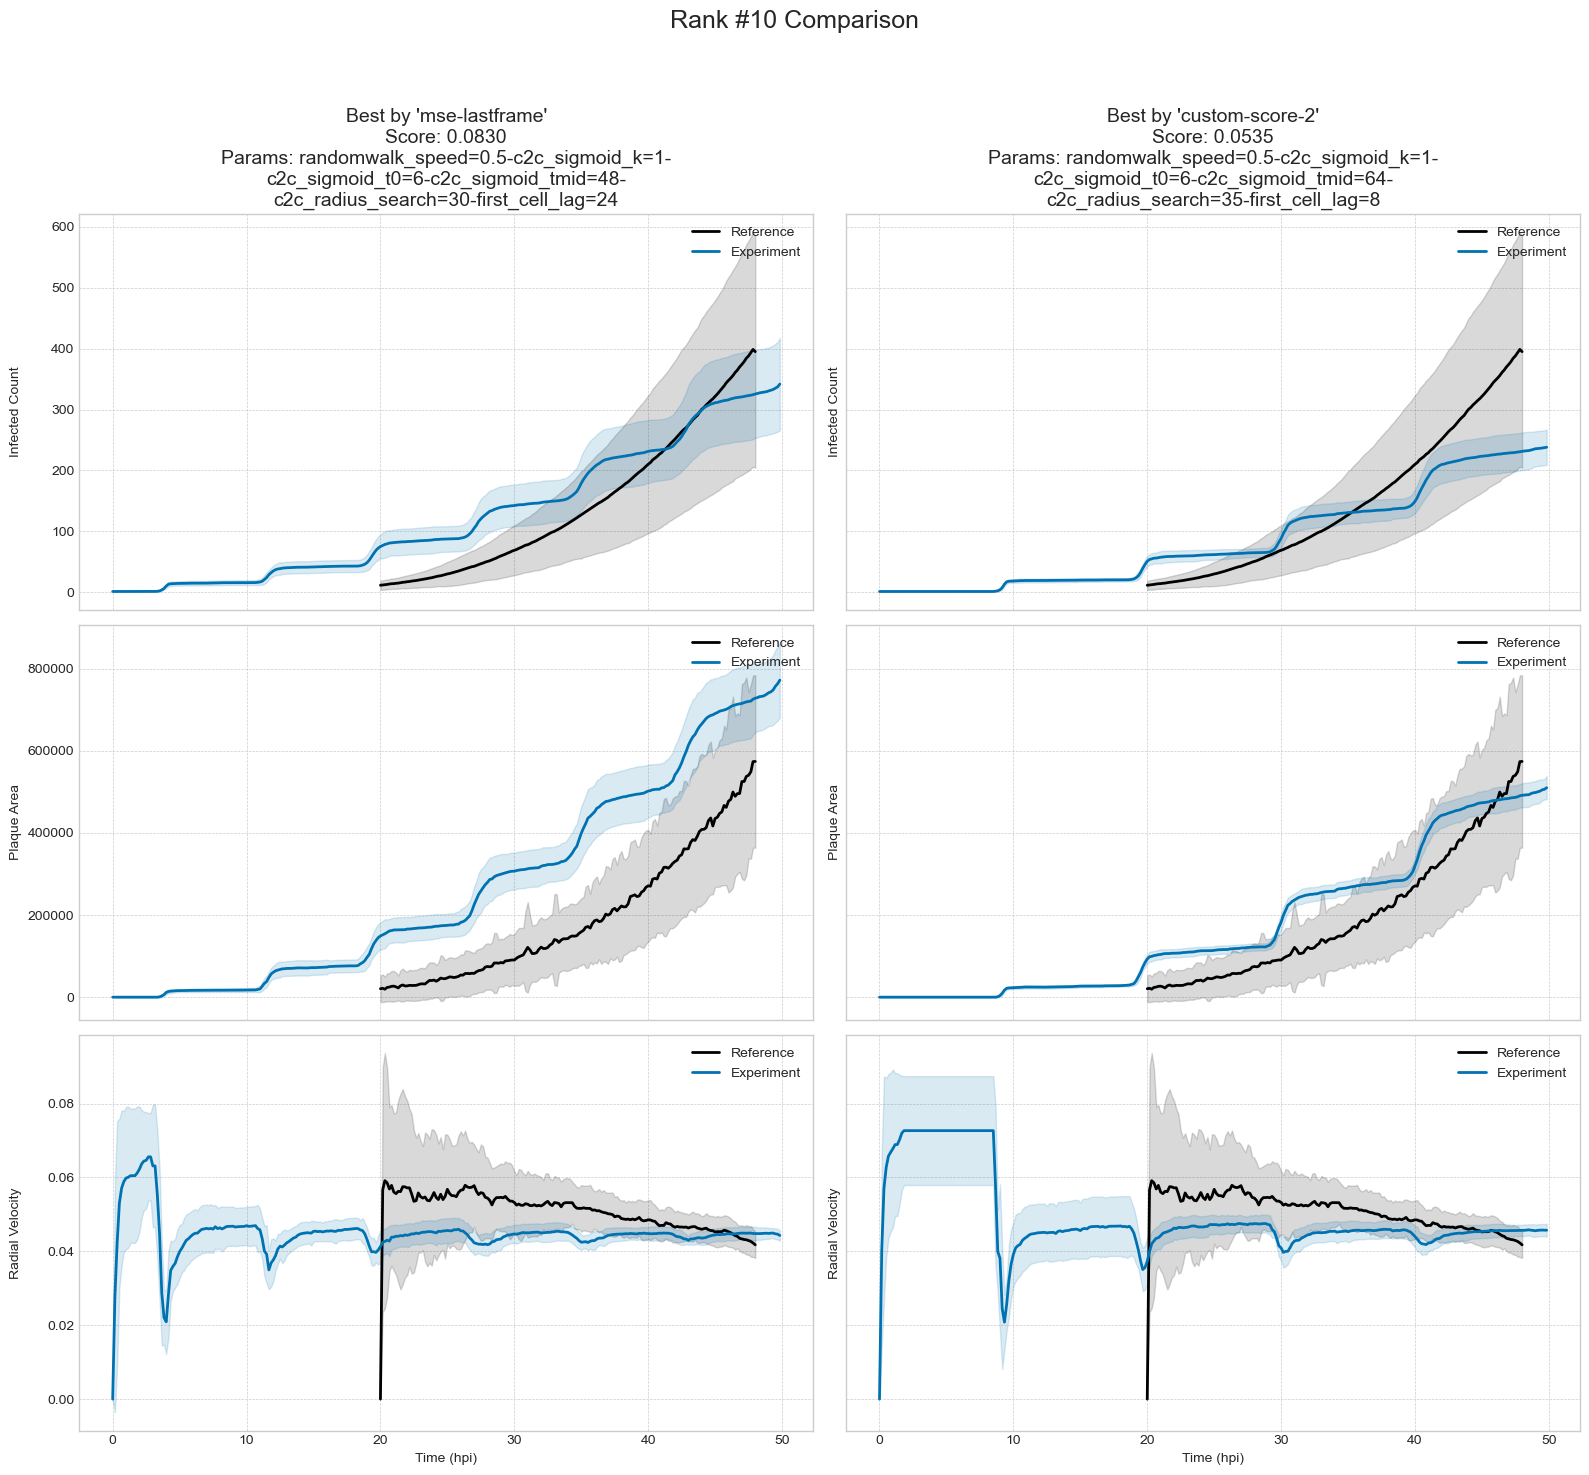


Finished generating comparison plots.


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import textwrap

# --- 1. PLOTTING CONFIGURATION ---
# Choose the two scores you want to compare from the SCORING_FUNCTIONS dictionary
SCORE_1_NAME = 'mse-lastframe'
SCORE_2_NAME = 'custom-score-2'

# Choose how many of the top ranks you want to plot
NUM_RANKS_TO_PLOT = 10
# ---------------------------------

# --- Helper function to avoid duplicating plot code ---
def plot_single_experiment(ax, filepath, metric_config, reference_data):
    """Plots a single reference vs. experiment comparison on a given axis."""
    col_name = metric_config['col']
    try:
        ref_mean, ref_std = reference_data[col_name]
        exp_mean, exp_std = get_stats_from_file(filepath, col_name)

        ax.plot(ref_mean.index, ref_mean, color='black', linewidth=2, label='Reference')
        ax.fill_between(ref_mean.index, ref_mean - ref_std, ref_mean + ref_std, color='black', alpha=0.15)
        ax.plot(exp_mean.index, exp_mean, color='#0072B2', linewidth=2, label='Experiment')
        ax.fill_between(exp_mean.index, exp_mean - exp_std, exp_mean + exp_std, color='#0072B2', alpha=0.15)
        
        ax.set_ylabel(metric_config['name'])
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    except Exception as e:
        ax.text(0.5, 0.5, f"Error plotting:\n{e}", ha='center', va='center', color='red')
        print(f"ERROR plotting metric '{col_name}' for file {os.path.basename(filepath)}: {e}")

# --- Main Plotting Logic ---
# First, sort the results DataFrame according to each score
# Note: For scores where higher is better (like R-squared), change ascending to False.
ranked_by_score1 = results_df.sort_values(by=SCORE_1_NAME, ascending=True).reset_index(drop=True)
ranked_by_score2 = results_df.sort_values(by=SCORE_2_NAME, ascending=True).reset_index(drop=True)

print(f"Comparing Top {NUM_RANKS_TO_PLOT} experiments for '{SCORE_1_NAME}' vs. '{SCORE_2_NAME}'...")

# Loop through the ranks you want to display
for rank_idx in range(min(NUM_RANKS_TO_PLOT, len(results_df))):
    rank_num = rank_idx + 1

    # Get the experiment details for this rank for both scores
    exp1_row = ranked_by_score1.iloc[rank_idx]
    exp2_row = ranked_by_score2.iloc[rank_idx]

    exp1_filepath = os.path.join(EXPERIMENTS_ROOT_DIR, exp1_row['parameters'] + '.csv')
    exp2_filepath = os.path.join(EXPERIMENTS_ROOT_DIR, exp2_row['parameters'] + '.csv')

    exp1_score = exp1_row[SCORE_1_NAME]
    exp2_score = exp2_row[SCORE_2_NAME]

    # --- Create the plot for the current rank ---
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15), sharex=True, sharey='row')
    fig.suptitle(f"Rank #{rank_num} Comparison", fontsize=18, y=0.98)

    # Set titles for the two columns
    param_string1 = exp1_row['parameters']
    param_string2 = exp2_row['parameters']
    # Wrap the long parameter strings to prevent overlap (adjust 'width' as needed)
    wrapped_params1 = '\n'.join(textwrap.wrap(param_string1, width=45))
    wrapped_params2 = '\n'.join(textwrap.wrap(param_string2, width=45))
    axes[0, 0].set_title(f"Best by '{SCORE_1_NAME}'\nScore: {exp1_score:.4f}\nParams: {wrapped_params1}", fontsize=14)
    axes[0, 1].set_title(f"Best by '{SCORE_2_NAME}'\nScore: {exp2_score:.4f}\nParams: {wrapped_params2}", fontsize=14)

    
    # Loop through the metrics to create the subplots
    for i, metric in enumerate(METRICS_TO_PROCESS):
        # Plot for score 1 (left column)
        plot_single_experiment(axes[i, 0], exp1_filepath, metric, reference_data)

        # Plot for score 2 (right column)
        plot_single_experiment(axes[i, 1], exp2_filepath, metric, reference_data)

    axes[-1, 0].set_xlabel("Time (hpi)")
    axes[-1, 1].set_xlabel("Time (hpi)")
    
    fig.align_ylabels(axes[:, 0])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("\nFinished generating comparison plots.")